# 📌 Bike Rental Demand Prediction

This project analyzes bike rental demand using regression models. The goal is to predict the number of rented bikes based on weather and seasonal data.

In [15]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.stats.outliers_influence import variance_inflation_factor
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

## 📂 1. Data Loading & Overview

We will load the dataset and perform an initial exploration.

In [2]:
# Load dataset
df = pd.read_csv("data/day.csv")

# Display first rows
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


In [3]:
# Check dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


In [4]:
# Check missing values
missing_values = df.isnull().sum()

# Display dataset statistics
dataset_statistics = df.describe()

missing_values, dataset_statistics

(instant       0
 dteday        0
 season        0
 yr            0
 mnth          0
 holiday       0
 weekday       0
 workingday    0
 weathersit    0
 temp          0
 atemp         0
 hum           0
 windspeed     0
 casual        0
 registered    0
 cnt           0
 dtype: int64,
           instant      season          yr        mnth     holiday     weekday  \
 count  731.000000  731.000000  731.000000  731.000000  731.000000  731.000000   
 mean   366.000000    2.496580    0.500684    6.519836    0.028728    2.997264   
 std    211.165812    1.110807    0.500342    3.451913    0.167155    2.004787   
 min      1.000000    1.000000    0.000000    1.000000    0.000000    0.000000   
 25%    183.500000    2.000000    0.000000    4.000000    0.000000    1.000000   
 50%    366.000000    3.000000    1.000000    7.000000    0.000000    3.000000   
 75%    548.500000    3.000000    1.000000   10.000000    0.000000    5.000000   
 max    731.000000    4.000000    1.000000   12.000000   

## 🛠 2. Data Cleaning

Data preprocessing includes handling categorical variables, missing values, and feature engineering.

In [5]:
# Function to clean and preprocess dataset
def clean_data(df):
    # Convert date column to datetime format
    df['dteday'] = pd.to_datetime(df['dteday'])

    # Drop the 'instant' column since it's just an index
    df.drop(columns=['instant'], inplace=True)

    # Replace categorical values with meaningful labels
    season_mapping = {1: 'Winter', 2: 'Spring', 3: 'Summer', 4: 'Fall'}
    weather_mapping = {1: 'Clear', 2: 'Cloudy', 3: 'Light Rain', 4: 'Heavy Rain'}

    df['season'] = df['season'].map(season_mapping)
    df['weathersit'] = df['weathersit'].map(weather_mapping)

    return df

# Apply cleaning function
df = clean_data(df)

df.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,2011-01-01,Winter,0,1,0,6,0,Cloudy,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2011-01-02,Winter,0,1,0,0,0,Cloudy,0.363478,0.353739,0.696087,0.248539,131,670,801
2,2011-01-03,Winter,0,1,0,1,1,Clear,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,2011-01-04,Winter,0,1,0,2,1,Clear,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,2011-01-05,Winter,0,1,0,3,1,Clear,0.226957,0.229270,0.436957,0.186900,82,1518,1600


## 📊 3. Exploratory Data Analysis (EDA)

Let's analyze trends and correlations between variables.

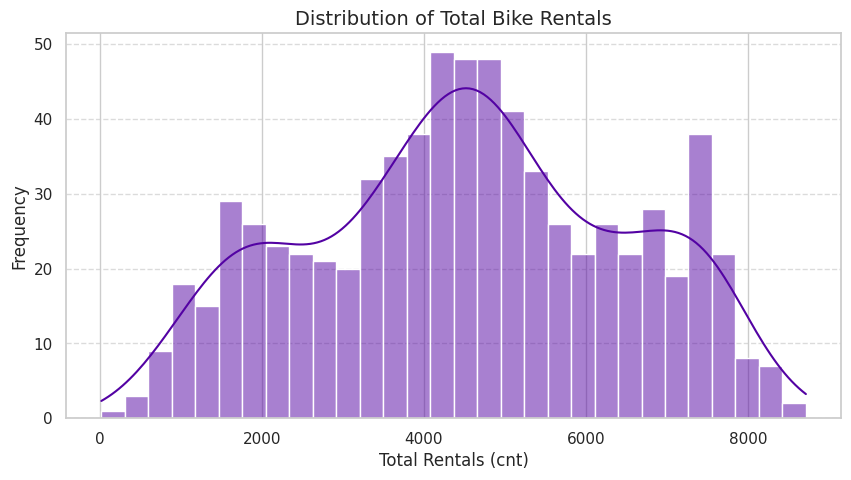

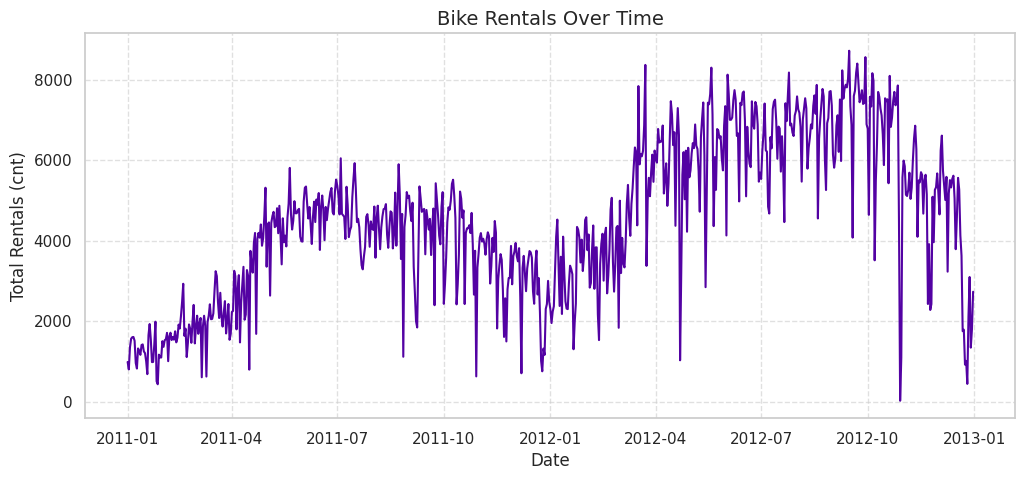

In [6]:
sns.set_theme(style="whitegrid", palette="plasma")

# Function to plot target variable distribution
def plot_target_distribution(df):
    plt.figure(figsize=(10, 5))
    sns.histplot(df['cnt'], bins=30, kde=True)
    plt.title("Distribution of Total Bike Rentals", fontsize=14)
    plt.xlabel("Total Rentals (cnt)")
    plt.ylabel("Frequency")
    plt.grid(axis="y", linestyle="--", alpha=0.7)
    plt.show()

# Function to visualize bike rentals over time
def plot_rentals_over_time(df):
    plt.figure(figsize=(12, 5))
    sns.lineplot(x=df['dteday'], y=df['cnt'])
    plt.title("Bike Rentals Over Time", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Total Rentals (cnt)")
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.show()

plot_target_distribution(df)
plot_rentals_over_time(df)

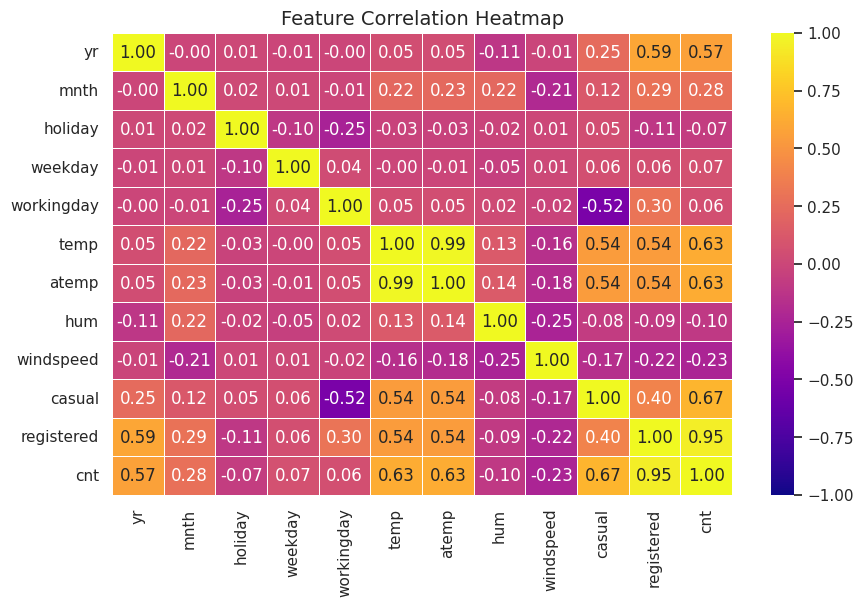

In [7]:
# Function to plot correlation heatmap
def plot_correlation_heatmap(df):
    numeric_df = df.select_dtypes(include=['number'])
    plt.figure(figsize=(10, 6))
    correlation_matrix = numeric_df.corr()
    
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="plasma", linewidths=0.5, vmin=-1, vmax=1)
    
    plt.title("Feature Correlation Heatmap", fontsize=14)
    plt.show()

# Apply function
plot_correlation_heatmap(df)

In [8]:
# Function to calculate VIF
def calculate_vif(df):
    # Select only numerical columns
    numeric_df = df.select_dtypes(include=[np.number])

    # Drop cnt because it's the target variable
    numeric_df = numeric_df.drop(columns=['cnt'])

    # Compute VIF for each feature
    vif_data = pd.DataFrame()
    vif_data["Feature"] = numeric_df.columns
    vif_data["VIF"] = [variance_inflation_factor(numeric_df.values, i) for i in range(len(numeric_df.columns))]
    return vif_data

# Apply function
vif_results = calculate_vif(df)


vif_results

,Feature,VIF
0,yr,4.718997
1,mnth,6.028431
2,holiday,1.105596
3,weekday,3.216474
4,workingday,9.137948
5,temp,492.150423
6,atemp,570.711976
7,hum,14.574627
8,windspeed,5.210148
9,casual,8.554379


In [9]:
# Function to remove highly collinear features
def remove_multicollinear_features(df):
    df = df.drop(columns=['atemp', 'casual', 'registered', 'hum'])
    return df

# Apply function
df = remove_multicollinear_features(df)

# Verify new VIF scores
vif_results = calculate_vif(df)
vif_results

,Feature,VIF
0,yr,1.941636
1,mnth,4.281838
2,holiday,1.090441
3,weekday,3.007057
4,workingday,3.098898
5,temp,6.571770
6,windspeed,4.465008


In [10]:
# Define features (X) and target variable (y)
# Drop target variable
X = df.drop(columns=['cnt'])  
# Target variable
y = df['cnt']  

# Convert categorical variables to numerical (season and weathersit)
X['season'] = X['season'].astype('category').cat.codes
X['weathersit'] = X['weathersit'].astype('category').cat.codes

# Convert date to ordinal values (number of days since 1970)
X['dteday'] = X['dteday'].map(lambda x: x.toordinal())

# Split into training (80%) and test (20%) sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape, y_train.shape)
print("Test set size:", X_test.shape, y_test.shape)

Training set size: (584, 10) (584,)
Test set size: (147, 10) (147,)


## 🏗 4. Feature Engineering

Transforming data to improve model performance.

In [11]:
# Initialize scaler
scaler = StandardScaler()

# Select only numerical features
numeric_features = X_train.select_dtypes(include=['number']).columns

# Fit and transform training data
X_train_scaled = scaler.fit_transform(X_train[numeric_features])
X_test_scaled = scaler.transform(X_test[numeric_features])

# Convert back to DataFrame with original column names and indices
X_train_scaled = pd.DataFrame(X_train_scaled, columns=numeric_features, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=numeric_features, index=X_test.index)

# Replace only numerical columns with scaled values
X_train[numeric_features] = X_train_scaled
X_test[numeric_features] = X_test_scaled


X_train.head()

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,windspeed
682,1.486810,-1.360406,0.966320,1.322914,-0.162364,-0.485466,0.702571,1.087238,-0.864610,1.957045
250,-0.567408,0.453469,-1.034854,0.739173,-0.162364,0.502381,0.702571,2.906570,0.737288,0.026719
336,-0.158466,-1.360406,-1.034854,1.614785,-0.162364,1.490229,-1.423344,-0.732094,-1.108087,-1.226972
260,-0.519857,0.453469,-1.034854,0.739173,-0.162364,-1.473314,-1.423344,-0.732094,0.040404,-0.157718
543,0.825846,0.453469,0.966320,-0.136440,-0.162364,0.008458,0.702571,-0.732094,1.087829,1.048487


## 🚀 5. Model Training

Training different regression models to compare performance.

In [14]:
# Define models
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100, random_state=42),
    "XGBoost": xgb.XGBRegressor(n_estimators=100, random_state=42)
}

# Store results
results = []

# Train and evaluate each model
for name, model in models.items():
    model.fit(X_train, y_train)  # Train model
    y_pred = model.predict(X_test)  # Make predictions
    
    # Calculate metrics
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = mse ** 0.5
    r2 = r2_score(y_test, y_pred)
    
    # Store results
    results.append({
        "Model": name,
        "MAE": mae,
        "RMSE": rmse,
        "R² Score": r2
    })

# Convert results to DataFrame and display
results_df = pd.DataFrame(results).sort_values(by="RMSE", ascending=True)
from IPython.display import display
display(results_df)

,Model,MAE,RMSE,R² Score
2,Gradient Boosting,475.238514,704.059016,0.876381
3,XGBoost,484.492212,759.035879,0.856321
1,Random Forest,501.476803,798.791973,0.840876
0,Linear Regression,636.111061,861.233224,0.815026


## 🎯 6. Hyperparameter Optimization

Using `RandomizedSearchCV` to fine-tune the best model.

In [16]:
# Define the hyperparameter search space
param_dist = {
    "n_estimators": np.arange(50, 300, 50),
    "learning_rate": np.linspace(0.01, 0.3, 10),
    "max_depth": np.arange(3, 10),
    "subsample": np.linspace(0.5, 1.0, 5),
    "min_samples_split": np.arange(2, 10),
    "min_samples_leaf": np.arange(1, 10)
}

# Initialize the model
gb_model = GradientBoostingRegressor(random_state=42)

# Configure RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=gb_model,
    param_distributions=param_dist,
    n_iter=20,  # Number of combinations to test
    scoring="neg_root_mean_squared_error",
    cv=5,  # 5-fold cross-validation
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

# Run the hyperparameter search
random_search.fit(X_train, y_train)

# Retrieve the best parameters
best_params = random_search.best_params_
print("Best hyperparameters found:", best_params)

# Train the best model with optimal parameters
best_gb = GradientBoostingRegressor(**best_params, random_state=42)
best_gb.fit(X_train, y_train)

# Evaluate the optimized model
y_pred_best = best_gb.predict(X_test)

# Compute metrics
mae_best = mean_absolute_error(y_test, y_pred_best)
rmse_best = mean_squared_error(y_test, y_pred_best) ** 0.5
r2_best = r2_score(y_test, y_pred_best)


print(f"MAE: {mae_best:.2f}")
print(f"RMSE: {rmse_best:.2f}")
print(f"R² Score: {r2_best:.4f}")

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=5, min_samples_split=4, n_estimators=150, subsample=0.5; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=7, min_samples_leaf=7, min_samples_split=8, n_estimators=100, subsample=0.875; total time=   0.2s
[CV] END learning_rate=0.3, max_depth=7, min_samples_leaf=7, min_samples_split=8, n_estimators=100, subsample=0.875; total time=   0.2s
[CV] END learning_rate=0.042222222222222223, max_depth=4, min_samples_leaf=7, min_samples_split=9, n_estimators=250, subsample=0.5; total time=   0.3s
[CV] END learning_rate=0.042222222222222223, max_depth=4, min_samples_leaf=7, min_samples_split=9, n_estimators=250, subsample=0.5; total time=   0.3s
[CV] END learning_rate=0.3, max_depth=7, min_samples_leaf=7, min_samples_split=8, n_estimators=100, subsample=0.875; total time=   0.3s
[CV] END learning_rate=0.01, max_depth=3, min_samples_leaf=5, min_samples_split=4, n_estimato

## 📌 7. Results & Conclusion

We evaluate the best model and summarize findings.

<h1>Machine Learning Model Optimization</h1>
<p>This project focuses on training and optimizing a <b>Gradient Boosting</b> model.</p>

<h2>Results</h2>
<h3>Before Optimization:</h3>
<ul>
    <li><b>MAE:</b> 475.24</li>
    <li><b>RMSE:</b> 704.06</li>
    <li><b>R² Score:</b> 0.8764</li>
</ul>

<h3>After Optimization:</h3>
<ul>
    <li><b>MAE:</b> 441.68</li>
    <li><b>RMSE:</b> 685.35</li>
    <li><b>R² Score:</b> 0.8829</li>
</ul>

<h2>Conclusion</h2>
<p>The hyperparameter tuning process significantly improved the model performance, reducing error metrics and increasing the R² Score.</p>
 the R² Score.


In [20]:
print(f'Best Model: Gradient Boosting')
print(f'MAE: {mae_best:.2f}')
print(f'RMSE: {rmse_best:.2f}')
print(f'R² Score: {r2_best:.4f}')

Best Model: Gradient Boosting
MAE: 441.68
RMSE: 685.35
R² Score: 0.8829


### ✅ Key Takeaways
- **Data cleaning** and feature engineering significantly impact model performance.
- **Gradient Boosting** performed the best after hyperparameter tuning.
- Further improvements can include feature selection and deep learning approaches.